In [1]:
import numpy as np
import thunder as td
import matplotlib.pyplot as plt
from glob import glob
from fish.util.fileio import load_image
import matplotlib as mpl
mpl.rcParams.update({'font.size': 22, 'font.family': 'sans-serif', 'font.sans-serif' : 'Arial'})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [2]:
base_dirs = ['/groups/ahrens/ahrenslab/FROM_TIER2/Yu/SPIM/active_datasets/20170228/fish4/20170228_4_1_gfaprgeco_hucgc_6dpf_shorttrials_20170228_185002/']
paths = dict()
cur_exp = -1
paths['base'] = base_dirs[cur_exp]
paths['raw'] = paths['base'] + 'raw/'
paths['reg'] = paths['base']
paths['ephys'] = paths['base'] + 'ephys/'

from h5py import File 
epdat = {}
with File(paths['ephys'] + 'data.mat') as f: 
    for k in f['data'].keys():
        epdat[k] = np.squeeze(f['data'][k][:])

from scipy.io import loadmat
trial_info = loadmat(paths['ephys'] + 'trial_info.mat')['trial_info']
gu_inds = np.where(trial_info[:,-1] == 1)[0]
ngu_inds = np.where(trial_info[:,-1] == 3)[0]

fmts = ['stack','tif','h5','klb']
fnames = glob(paths['raw'] + 'TM*')
# make sure all the filenames correspond to files with valid image formats
fnames = [f for f in fnames if f.split('.')[-1] in fmts ]

fnames.sort()    
print('Num raw images: {0}'.format(len(fnames)))

from fish.image.vol import get_stack_freq
fs_im = 1 / get_stack_freq(paths['raw'])[0]    
print('Sampling rate:  {0} Hz'.format(1 / fs_im))

# set correct aspect ratio for plotting
from fish.image.vol import get_metadata
exp_data = get_metadata(paths['raw'] + 'ch0.xml')
bidirectional_stack = exp_data['bidirectional_stack'] == 'T'
z_step = exp_data['z_step']
aspect = (int(z_step / .406), 1, 1)
dims = exp_data['dimensions']
print('Dims : {}'.format(dims))
print('Bidirectional stack : {0}'.format(bidirectional_stack))

Num raw images: 7200
Sampling rate:  1.58 Hz
Dims : [2048 2048   29]
Bidirectional stack : False


In [3]:
ims = td.images.fromlist(fnames, accessor=load_image, engine=sc, npartitions=len(fnames)).median_filter(size=(1,3,3)).astype('float32')
if bidirectional_stack:
    from fish.image.vol import rearrange_bidirectional_stack
    ims = ims.map(rearrange_bidirectional_stack)

In [4]:
ims.shape

(7200, 29, 2048, 2048)

In [5]:
%%time
do_registration = True

try:
    from skimage.io import imread
    affs = np.load(paths['reg'] + 'regparams_affine.npy')
    ref = imread(paths['reg'] + 'anat_reference.tif')
    do_registration = False
    print('Registration params found')
except(FileNotFoundError):
    print('Registration params not found; performing registration')
    do_registration = True

if do_registration:
    ref_range = (len(fnames) // 2) + np.arange(-5,5)
    ref = td.images.fromlist(np.array(fnames)[ref_range], accessor=load_image)
    ref = ref.median_filter(size=(1,3,3)).mean().toarray().astype('float32')

    if bidirectional_stack:
        ref = rearrange_bidirectional_stack(ref)

    # save reference image to disk 
    from skimage.io import imsave
    from os import makedirs
    from os.path import exists
    if not exists(paths['reg']):
        makedirs(paths['reg'])
    imsave(paths['reg'] + 'anat_reference.tif', ref.astype('uint16'), compress=1)
    
    from fish.image.alignment import estimate_translation
        
    reg = ims.map(lambda v: estimate_translation(ref.max(0), v.max(0))).toarray()    
    affs = np.array([r.affine for r in reg])
    np.save(paths['reg'] + 'regparams_affine.npy', affs)

Registration params found
CPU times: user 1.16 s, sys: 311 ms, total: 1.47 s
Wall time: 3 s


/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


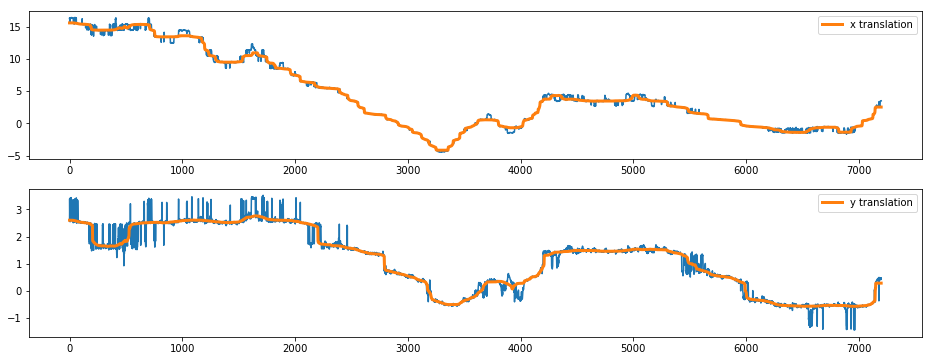

In [6]:
from scipy.ndimage.filters import median_filter
fig, axs = plt.subplots(nrows=2, figsize=(16,6))
x_trans_raw = affs[:, -2, -1]
y_trans_raw = affs[:, 0, -1]
x_trans = median_filter(x_trans_raw, size=200)
y_trans = median_filter(y_trans_raw, size=200)
z_trans = np.zeros(x_trans.shape)
trans = np.vstack([z_trans, y_trans, x_trans])

axs[0].plot(x_trans_raw)
axs[0].plot(x_trans, linewidth=3, label = 'x translation')
axs[0].legend()
axs[1].plot(y_trans_raw)
axs[1].plot(y_trans, linewidth=3, label = 'y translation')
axs[1].legend()

In [65]:
hist = np.histogram(ref.ravel()[::100], np.arange(ref.min(), ref.max()))
pixel_baseline = np.round(hist[1][np.argmax(hist[0])]) - 2 * ref.ravel()[::10].std()
print(pixel_baseline)

83.1280388529


In [51]:
from scipy.ndimage.interpolation import shift

# important to apply -1 * translation
ims_registered = ims.map(lambda v: shift(v[1], -trans[:, v[0][0]], cval=pixel_baseline), with_keys=True).astype('float32')

In [9]:
def dff(v, window, offset=10, perc=20):
    from scipy.ndimage.filters import percentile_filter
    baseline = percentile_filter(v, size=window, percentile=perc)
    return ((v - baseline) / (baseline + offset)).astype('float32')

In [69]:
%%time
# take 300s baseline
baseline_window = int(300 / fs_im)
baseline_offset = 10
ds = 4

# subtract pixel baseline
ims_registered_bgr = ims_registered.map(lambda v: np.clip(v - pixel_baseline, a_min=0, a_max=None))
my_dff = lambda v: dff(v, window=baseline_window, offset=baseline_offset)
ims_ds = ims_registered_bgr.uniform_filter(size=(1,ds,ds))[:,:,::ds,::ds]
ims_ds.cache()
ims_ds.count()
dims_ds = ims_ds.shape
ims_dff = ims_ds.map_as_series(my_dff, value_size=ims_ds.shape[0], dtype='float32')

CPU times: user 14.8 s, sys: 1.45 s, total: 16.3 s
Wall time: 37min 37s


In [70]:
%%time
mx_ims = ims_dff.max().toarray()

CPU times: user 2.03 s, sys: 880 ms, total: 2.91 s
Wall time: 21min 17s


/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


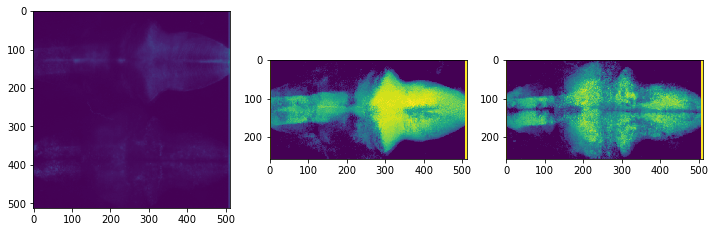

In [83]:
dff_thr = .2
mask = mx_ims > dff_thr
g_coords = (slice(0,None), slice(0, mask.shape[1] // 2), slice(0, None))
n_coords = (slice(0,None), slice(mask.shape[1] // 2, None), slice(0, None))
mask_g = mask[g_coords]
mask_n = mask[n_coords]

fig, axs = plt.subplots(ncols=3, figsize=(12,4))
axs[0].imshow(mx_ims.mean(0))
axs[1].imshow(mask_g.sum(0))
axs[2].imshow(mask_n.sum(0))

In [84]:
dff_means = ims_dff.map(lambda v: [v[g_coords][mask_g].mean(), v[n_coords][mask_n].mean()]).toarray()

In [85]:
dff_means.shape

(7200, 2)

In [86]:
np.save('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/20170228-dff-whole-brain-means-gn.npy',
       dff_means)

## Start here if dff is already computed

In [87]:
dff_means = np.load('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/20170228-dff-whole-brain-means-gn.npy')

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


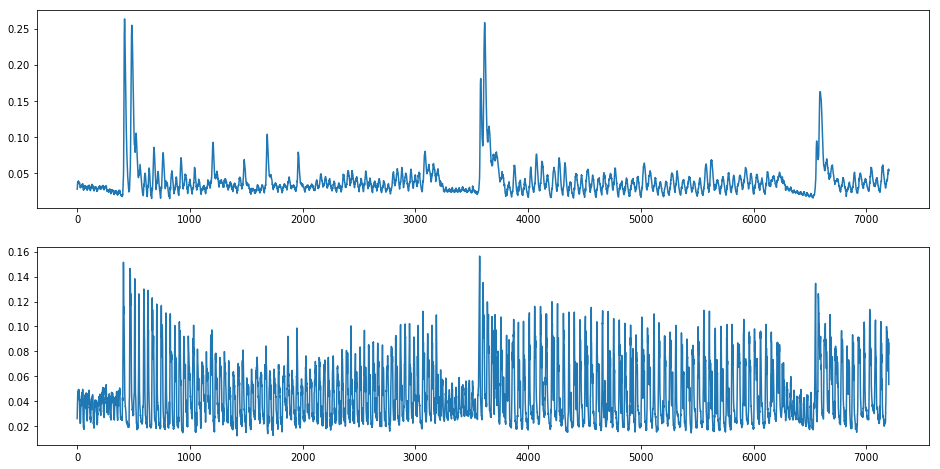

In [88]:
fig, axs = plt.subplots(nrows = 2, ncols = 1, figsize=(16,8))
axs[0].plot(dff_means[:,0])
axs[1].plot(dff_means[:,1])

In [89]:
from scipy.io import loadmat
pause_start = np.squeeze(loadmat(paths['ephys'] + 'pause_start.mat')['pause_start'])
trial_info = loadmat(paths['ephys'] + 'trial_info.mat')['trial_info']

# in trial_info, 1 means a trial was labelled "giving up" and 3 means "not giving up"
gu_inds = trial_info[np.where(trial_info[:,-1] == 1)[0],3]
ngu_inds = np.unique(trial_info[np.where(trial_info[:,-1] == 3)[0],3])

minlen = min(map(len, (gu_inds, ngu_inds))) - 1

gu_inds = gu_inds[:minlen]
ngu_inds = ngu_inds[:minlen]

frames_gu = epdat['frame'][gu_inds].astype('int')
frames_ngu = epdat['frame'][ngu_inds].astype('int')

In [90]:
window_im = np.arange(-20, 20)
triggered_means = {}
triggered_means['gu'] = []
triggered_means['ngu'] = []

for ind, val in enumerate(frames_gu):
    triggered_means['gu'].append(dff_means[val + window_im])

for ind, val in enumerate(frames_ngu):
    triggered_means['ngu'].append(dff_means[val + window_im])

triggered_means['gu'] = np.array(triggered_means['gu'])
triggered_means['ngu'] = np.array(triggered_means['ngu'])

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


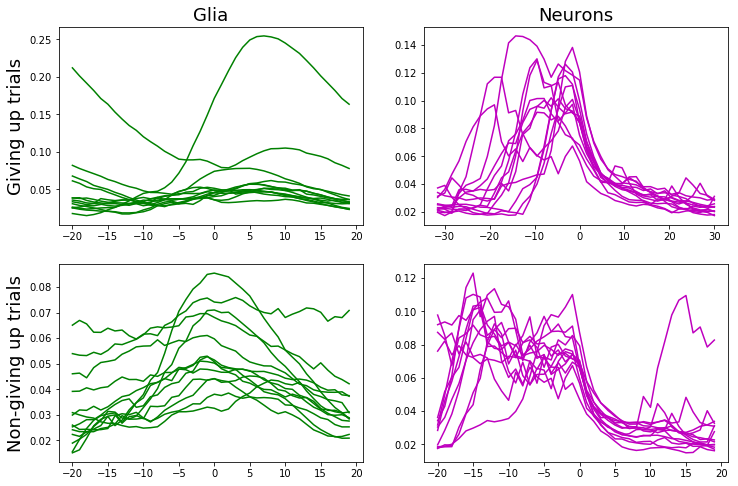

In [91]:
fig, axs = plt.subplots(nrows=2, ncols=2, sharey=False, figsize=(12,8))

axs[0][0].plot(window_im, triggered_means['gu'][:,:,0].T,'g');
axs[0][0].set_ylabel('Giving up trials', fontsize=18)
axs[0][0].title.set_fontsize(18)
axs[0][0].title.set_text('Glia')

axs[0][1].plot(window_im / fs_im, triggered_means['gu'][:,:,1].T,'m');
axs[0][1].title.set_fontsize(18)
axs[0][1].title.set_text('Neurons')

axs[1][0].plot(window_im, triggered_means['ngu'][:,:,0].T,'g');
axs[1][0].set_ylabel('Non-giving up trials', fontsize=18)
axs[1][1].plot(window_im, triggered_means['ngu'][:,:,1].T,'m');

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


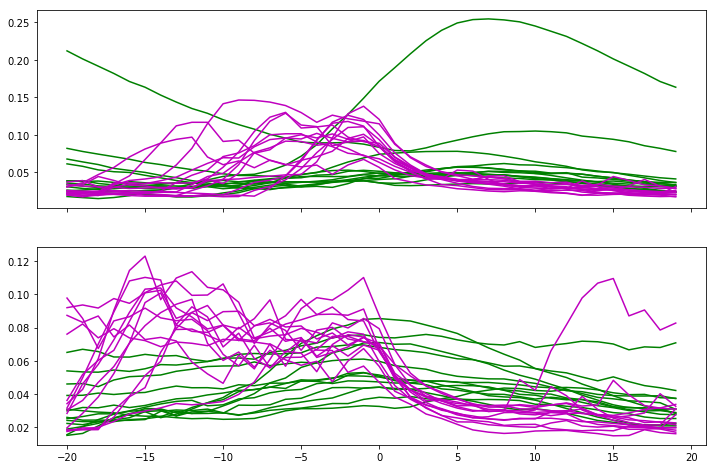

In [92]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharey=False, sharex=True, figsize=(12,8))
axs[0].plot(window_im, triggered_means['gu'][:,:,0].T,'g');
axs[0].plot(window_im, triggered_means['gu'][:,:,1].T,'m');
axs[1].plot(window_im, triggered_means['ngu'][:,:,0].T,'g');
axs[1].plot(window_im, triggered_means['ngu'][:,:,1].T,'m');

# Try outlier removal

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


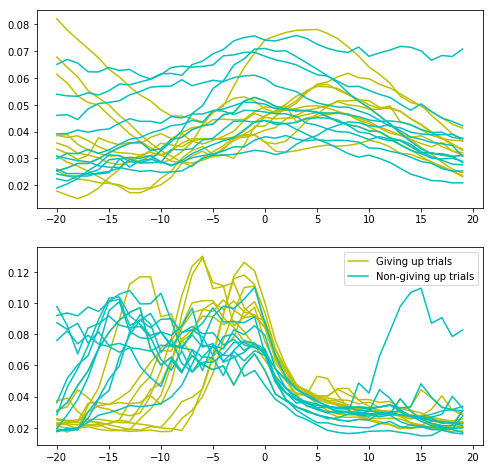

In [93]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,8))
plr_trials = slice(2,None)
axs[0].plot(window_im, triggered_means['gu'][plr_trials,:,0].T,'y');
axs[0].plot(window_im, triggered_means['ngu'][plr_trials,:,0].T,'c');

axs[1].plot(window_im, triggered_means['gu'][plr_trials,:,1].T,'y');
axs[1].plot(window_im, triggered_means['ngu'][plr_trials,:,1].T,'c');
#axs[0].legend([axs[0].lines[0], axs[0].lines[-1]], ['Giving up trials', 'Non-giving up trials'])
axs[1].legend([axs[1].lines[0], axs[1].lines[-1]], ['Giving up trials', 'Non-giving up trials'])

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


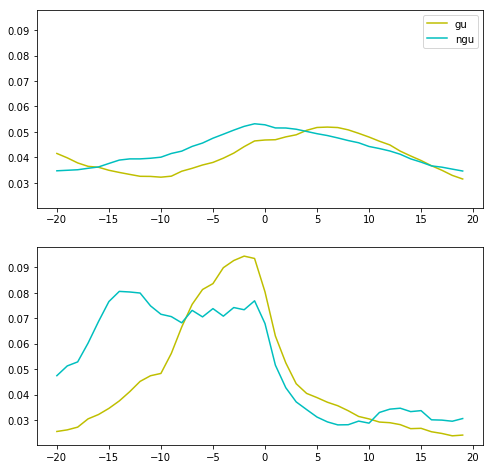

In [94]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8,8), sharey=True)
axs[0].plot(window_im, triggered_means['gu'][plr_trials,:,0].T.mean(1),'y', label='gu');
axs[0].plot(window_im, triggered_means['ngu'][plr_trials,:,0].T.mean(1),'c', label='ngu');
axs[1].plot(window_im, triggered_means['gu'][plr_trials,:,1].T.mean(1),'y');
axs[1].plot(window_im, triggered_means['ngu'][plr_trials,:,1].T.mean(1),'c');
axs[0].legend([axs[0].lines[0], axs[0].lines[-1]], ['gu', 'ngu'])

In [95]:
def mean_with_spread(data, x_axis, axis, spread_fun='sem', **kwargs):
    axis.plot(x_axis, data.mean(0), **kwargs)
    
    if spread_fun == 'sem':
        from scipy.stats import sem
        spread_fun = sem
    
    if spread_fun == 'std':
        from numpy import std
        spread_fun = std
    
    axis.fill_between(x_axis, data.mean(0) - spread_fun(data), data.mean(0) + spread_fun(data), **kwargs, alpha=.2)
    axis.set_xlim(x_axis[0], x_axis[-1])

In [96]:
def axis_fontsize(axis, fontsize):
    axis.tick_params(axis='both', which='major', labelsize=fontsize)
    axis.tick_params(axis='both', which='minor', labelsize=fontsize)

/groups/ahrens/home/bennettd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


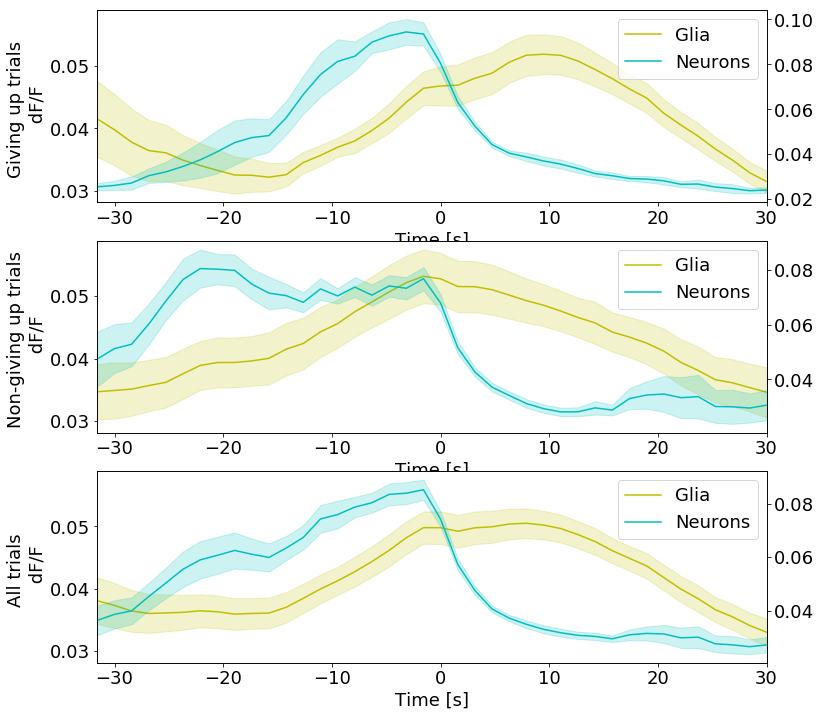

In [100]:
nr = 3

from scipy.stats import sem
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12,4  * nr), sharey=True)
x_axis = window_im / fs_im
plr_trials = slice(2, None)

for ind, val in enumerate(triggered_means):
    axs_g = axs[ind]
    axs_n = axs_g.twinx()
    mean_with_spread(triggered_means[val][plr_trials,:,0], x_axis, axs_g, color='y', label='Glia')
    mean_with_spread(triggered_means[val][plr_trials,:,1], x_axis, axs_n, color='c', label='Neurons')
    axs_g.legend([axs_g.lines[0], axs_n.lines[0]], [axs_g.lines[0].get_label(), axs_n.lines[0].get_label()], fontsize=18)
    #add_scalebar(axs_g)
    #add_scalebar(axs_n, loc=3)
    [axis_fontsize(axs, 18) for axs in [axs_g, axs_n]]

all_trials_g = np.vstack([triggered_means['gu'][plr_trials, :, 0], triggered_means['ngu'][plr_trials, :, 0]])
all_trials_n = np.vstack([triggered_means['gu'][plr_trials, :, 1], triggered_means['ngu'][plr_trials, :, 1]])

axs_g = axs[2]
axs_n = axs_g.twinx()
mean_with_spread(all_trials_g, x_axis, axs_g, color='y', label='Glia')
mean_with_spread(all_trials_n, x_axis, axs_n, color='c', label='Neurons')
axs_g.legend([axs_g.lines[0], axs_n.lines[0]], [axs_g.lines[0].get_label(), axs_n.lines[0].get_label()], fontsize=18)     
#add_scalebar(axs_g)
#add_scalebar(axs_n, loc=3)

axs[0].set_ylabel('Giving up trials \n dF/F', fontsize=18)
axs[1].set_ylabel('Non-giving up trials \n dF/F', fontsize=18)
axs[2].set_ylabel('All trials \n dF/F', fontsize=18)
[axis_fontsize(axs, 18) for axs in [axs_g, axs_n]]
[ax.set_xlabel('Time [s]', fontsize=18) for ax in axs]

plt.savefig('/groups/ahrens/ahrenslab/davis/tmp/20170228_glia_neurons_trial_averaged_gu.pdf')

In [98]:
# -*- coding: utf-8 -*-
# -*- mode: python -*-
# Adapted from mpl_toolkits.axes_grid1
# LICENSE: Python Software Foundation (http://docs.python.org/license.html)
# From C. Dan Meliza
from matplotlib.offsetbox import AnchoredOffsetbox
class AnchoredScaleBar(AnchoredOffsetbox):
    def __init__(self, transform, sizex=0, sizey=0, labelx=None, labely=None, loc=4,
                 pad=0.1, borderpad=0.1, sep=2, prop=None, **kwargs):
        """
        Draw a horizontal and/or vertical  bar with the size in data coordinate
        of the give axes. A label will be drawn underneath (center-aligned).
        - transform : the coordinate frame (typically axes.transData)
        - sizex,sizey : width of x,y bar, in data units. 0 to omit
        - labelx,labely : labels for x,y bars; None to omit
        - loc : position in containing axes
        - pad, borderpad : padding, in fraction of the legend font size (or prop)
        - sep : separation between labels and bars in points.
        - **kwargs : additional arguments passed to base class constructor
        """
        from matplotlib.patches import Rectangle
        from matplotlib.offsetbox import AuxTransformBox, VPacker, HPacker, TextArea, DrawingArea
        bars = AuxTransformBox(transform)
        if sizex:
            bars.add_artist(Rectangle((0,0), sizex, 0, fc="none", color='k'))
        if sizey:
            bars.add_artist(Rectangle((0,0), 0, sizey, fc="none", color='k'))

        if sizex and labelx:
            bars = VPacker(children=[bars, TextArea(labelx, minimumdescent=False)],
                           align="center", pad=0, sep=sep)
        if sizey and labely:
            bars = HPacker(children=[TextArea(labely), bars],
                            align="center", pad=0, sep=sep)

        AnchoredOffsetbox.__init__(self, loc, pad=pad, borderpad=borderpad,
                                   child=bars, prop=prop, frameon=False, **kwargs)


def add_scalebar(ax, matchx=True, matchy=True, hidex=True, hidey=True, **kwargs):
    """ Add scalebars to axes
    Adds a set of scale bars to *ax*, matching the size to the ticks of the plot
    and optionally hiding the x and y axes
    - ax : the axis to attach ticks to
    - matchx,matchy : if True, set size of scale bars to spacing between ticks
                    if False, size should be set using sizex and sizey params
    - hidex,hidey : if True, hide x-axis and y-axis of parent
    - **kwargs : additional arguments passed to AnchoredScaleBars
    Returns created scalebar object
    """
    def f(axis):
        l = axis.get_majorticklocs()
        return len(l)>1 and (l[1] - l[0])
    
    if matchx:
        kwargs['sizex'] = f(ax.xaxis)
        kwargs['labelx'] = str(kwargs['sizex'])
    if matchy:
        kwargs['sizey'] = f(ax.yaxis)
        kwargs['labely'] = str(kwargs['sizey'])
        
    sb = AnchoredScaleBar(ax.transData, **kwargs)
    ax.add_artist(sb)

    if hidex : ax.xaxis.set_visible(False)
    if hidey : ax.yaxis.set_visible(False)

    return sb